---
title: "Automatic differentiation in Julia"
author: "James Xu"
date: "2025-03-06"
engine: jupyter
format: 
  pdf:
    keep-tex: true
    include-in-header: 
       text: |
         \usepackage{fvextra}
         \DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaklines,commandchars=\\\{\}}
         \DefineVerbatimEnvironment{OutputCode}{Verbatim}{breaklines,commandchars=\\\{\}}
---

# Automatic Differentiation in Julia

## Automatic differentiation: The basics

### Some motivation - what is automatic differentiation and why is it useful?

Optimization is at the core of solving several scientific problems, from linear regression to drug discovery. To solve optimization problems there are also several methods such as heuristic algorithms (e.g. Genetic Algorithms & Partical Swarm Optmiization) and gradient-free methods (e.g. Bayesian optimization) that can be used. 

However, gradient-based methods have shown to be remarkably successful in the Scientific Machine Learning (SciML) world. To compute gradients, there again is a myriad of options such as analytical derivatives, finite-difference methods, symbolic differentiation, complex step differentiation, and adjoint state methods.

Today, we'll be focusing on Automatic Differentiation (AD) (also known as algorithmic differentiation, autodiff, computational differentiation), to compute derivatives. AD overcomes some of the cons of finite differences (which can be inaccurate for insufficiently small discretizations) and symbolic differentiation (which suffers from symbolic swelling).

Generally speaking, AD is a *method that generates code that represents derivatives of a given computer program defined by some evaluation procedure*. A concise history of AD can be found here [[2]](#2). Julia is a language that has a rich tradition in implementing packages that embody *differntiable programming* paradigm. 

*Julia is particularly well suited to do AD since it has efficient implementation of operator overloading.*

**Computational graphs**

Any computer program implementing a function can be seen as a sequence of simple algebraic operations that have simple derivative expressions. Then, via the chain rule, end-to-end differentiation can be performed. A particularly useful way to represent the computer program is a *computational graph*. The graph is directed and acyclic (DAG). It is comprised of nodes and edges. 

Nodes are functions that take in incoming edges and outputs values.

Edges represent data (scalar, vector, tensors, etc.).

In Julia, this is a data structure that can be represented as a computational graph.

Examining a function, 

$$ f(x) = x_{1}^{2} + 4(x_{2} - x_{1}) $$

Here, we can see the computational graph of $f$ as a DAG. Each node $v[i]$ has its own index $i$ and the mathematical operation that it corresponds to, and is connected by an edge from the previous node $v[h]$ that was the input to the operation.

```mermaid
flowchart LR
    n1["x[1]"] --> n3["^2"]
    n2["x[2]"] --> n4["−"]
    n1 --> n4
    n8["4.0"] --> n9["×"]
    n4 --> n9
    n3 --> n10["&plus;"]
    n9 --> n10
    n10 --> n11["f(x)"]
```

In [ ]:
x = [1.0, 2.0]

In [37]:
f_implicit(x) = x[1]^2 + 4*(x[2] - x[1])

f_implicit (generic function with 1 method)

We can reformulate this composite function to explicitly consider elemental operations one by one:

In [51]:
function f_explicit(x)
  v = zeros(6)
  
  # Load inputs
  v[1] = x[1]
  v[2] = x[2]
  
  # Node = Function(Node) 
  # Compute x[1]^2
  v[3] = v[1]^2
  
  # Compute (x[2] - x[1])
  v[4] = v[2] - v[1]
  
  # Multiply the difference by 4.0
  v[5] = 4.0 * v[4]
  
  # Sum the squared term and the scaled difference
  v[6] = v[3] + v[5]
  
  return v[6]
end

f_explicit (generic function with 1 method)

In [50]:
println("Implicit function output: ",f_implicit(x))
println("Explicit function output: ",f_explicit(x))

Implicit function output: 5.0
Explicit function output: 5.0


In [44]:
@code_native f_implicit(x)

	.text
	.file	"f_implicit"
	.section	.rodata.cst8,"aM",@progbits,8
	.p2align	3, 0x0                          # -- Begin function julia_f_implicit_8561
.LCPI0_0:
	.quad	0x4010000000000000              # double 4
	.text
	.globl	julia_f_implicit_8561
	.p2align	4, 0x90
	.type	julia_f_implicit_8561,@function
julia_f_implicit_8561:                  # @julia_f_implicit_8561
; Function Signature: f_implicit(Array{Float64, 1})
; ┌ @ c:\Users\jxu20\Documents\coursework\stat244\final-project\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:1 within `f_implicit`
	.cfi_startproc
# %bb.0:                                # %top
; │ @ c:\Users\jxu20\Documents\coursework\stat244\final-project\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl within `f_implicit`
	#DEBUG_VALUE: f_implicit:x <- [DW_OP_deref] $rcx
	#DEBUG_VALUE: f_implicit:x <- [DW_OP_deref] 0
	push	rbp
	.cfi_def_cfa_offset 16
	.cfi_offset rbp, -16
	mov	rbp, rsp
	.cfi_def_cfa_register rbp
	sub	rsp, 32
; │ @ c:

In [43]:
@code_native f_explicit(x)

	.text
	.file	"f_explicit"
	.section	.rodata.cst8,"aM",@progbits,8
	.p2align	3, 0x0                          # -- Begin function julia_f_explicit_8473
.LCPI0_0:
	.quad	0x4010000000000000              # double 4
	.text
	.globl	julia_f_explicit_8473
	.p2align	4, 0x90
	.type	julia_f_explicit_8473,@function
julia_f_explicit_8473:                  # @julia_f_explicit_8473
; Function Signature: f_explicit(Array{Float64, 1})
; ┌ @ c:\Users\jxu20\Documents\coursework\stat244\final-project\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:1 within `f_explicit`
	.cfi_startproc
# %bb.0:                                # %L53
; │ @ c:\Users\jxu20\Documents\coursework\stat244\final-project\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl within `f_explicit`
	#DEBUG_VALUE: f_explicit:x <- [DW_OP_deref] $rcx
	push	rbp
	.cfi_def_cfa_offset 16
	.cfi_offset rbp, -16
	mov	rbp, rsp
	.cfi_def_cfa_register rbp
	push	rsi
	sub	rsp, 40
	.cfi_offset rsi, -24
	mov	rsi, rcx
; │ @ c

**Dual Numbers**

A popular way to implement forward mode AD is to use dual numbers [[6]](#6). They can be seen as an extension from complex step differntiation. 


<u>Finite Difference Methods</u>

We'll motivate this method by starting from something that we're all familiar with, finite differences. In particular, the central difference method to approximate first-order derivatives is given by

$$ f'(x) = \frac{f(x+h) - f(x-h)}{2h} +\mathcal{O}(h^{2}) $$

Some pros are that it's easy to implement. Some cons of this method are that you have $\mathcal{O}(h^{2})$ truncation error, if $h$ is very small, then you get the familiar subtractive cancellation error, and that you need to evaluate $f$ twice.

<u>Complex Step Methods</u>

So the complex step method was created to mitigate/remove some of these issues. Essentially, you take a step as an imaginary part. You can then take a Taylor series expansion of $f(x+ih)$ as

$$ f(x + ih) = f(x) ih + \frac{f''(x)}{2!} i^{2} h^{2} + \cdots     $$

We can then look at the derivative by only looking at the imaginary part,

$$ f'(x) = \frac{\mathcal{Im}[ f(x+ih)]}{h} + \mathcal{O}(h^{2}) $$

And so we have no subtractive cancellation error, only need to call $f$ once, truncation error can be very small (nearly machine error) by making h very small. However, complex number operations can be slower than real number operations, and this method may not really work for programs that already have complex inputs.

<u>Dual Numbers</u>

We can represent dual numbers using the representation $a+b \varepsilon$, where $\varepsilon^{2} = 0, \varepsilon \neq 0$. 

*Addition definition*
$$ (a+b \varepsilon) + (c+d \varepsilon) = (a + c) + (b + d) \varepsilon$$

*Mulitplication definition*

$$ (a+b \varepsilon)  (c+d \varepsilon) = ac + (ad + bc)\varepsilon + db \varepsilon^{2} = ac + (ad + bc)\varepsilon  $$


Say we're interested in getting the first order derivative of a function $f$ that is $n+1$-differentiable. Recalling Taylor expansion at a point, $x_{0}$,

$$ f(x) = f(x_{0}) + f'(x_{0}) (x-x_{0}) + \cdots + \frac{f^{(n)} (x_{0})}{n!} (x-x_{0})^{n}  +h.o.t.  $$


Now plugging in our dual number, and setting $b = 1$, we obtain

\begin{align} 
f(a + \varepsilon) & = f(a) + f'(a) (\varepsilon) + \cdots + \frac{f^{(n)} (a)}{n!} (\varepsilon)^{n}  +h.o.t. \\
& = f(a) + f'(a) (\varepsilon) \\
f'(a) & = \mathcal{Eps}[ f(a+\varepsilon)]
\end{align}

We now have the real part which is the original function value at $a$, and the dual part, where the coefficient in front of $\varepsilon$ is the derivative of $f$ at $a$. The key point is that now, when you do arithmetic operations like addition and multiplications, you carry *exact* derivative information. *Note that we have no approximation error since $\varepsilon^{2} = 0$ in contrast to $i^{2} = -1$*. 


For example, $f(x) = x^{2}$, evaluated at a dual number $a+\varepsilon$, we have

\begin{align}
    f(a+\varepsilon) & = (a +\varepsilon )^{2} \\
    & = a^{2} + 2 a \varepsilon + \varepsilon^{2} \\
    & = a^{2} + 2 a \varepsilon \\
    \implies f(a) & = \mathcal{Re} [ a^{2} + 2 a \varepsilon] \\
    & = a^{2} \\
    \implies f'(a) & = \mathcal{Eps} [ a^{2} + 2 a \varepsilon ] \\
    & = 2 a \\
\end{align}

So we see we can get the first order gradient with just a substitution of a dual number!

In [173]:
using Base

struct DualNumber{T}
    real::T;
    dual::T;
end

Base.:*(a::DualNumber, b::DualNumber) = DualNumber(a.real*b.real, a.real*b.dual + a.dual*b.real)

function pushforward(f, primal::Real, tangent::Real)
    input = DualNumber(primal, tangent)
    output = f(input)
    primal_out = output.real
    tangent_out = output.dual
    return primal_out, tangent_out
end

function derivative(f, x::Real)
    v = one(x)
    _, df_dx = pushforward(f, x, v)
    return df_dx
end

f_dual_test(x) = x * x

x_dual_test = 3.0

println("f(x) = x*x = ",f_dual_test(x_dual_test))

println("f'(x) = 2x = ", derivative(f_dual_test, x_dual_test))

f(x) = x*x = 9.0
f'(x) = 2x = 6.0


**Reverse-mode vs Forward-mode AD**

AD referes to propagating the gradients in the computational graph. But there are two ways to do this, namely Reverse-mode vs Forward-mode AD.

Forward-mode AD: Propagate gradients in the same direction as the forward computation. This can be implemented in various ways depending on the data structure used when representing a computer program, such as dual numbers and computational graphs [[1]](#1). Dual numbers are typically used for forward mode AD and not reverse mode AD.

Reverse-mode AD: Propagate gradients in the reverse direction of the forward computation.
(aka: adjoint, cotangent linear mode, or backpropagation)

Let's try to understand when we should use Reverse-mode vs Forward-mode. Let's say we have a composition of functions,

$$ F(x) = f_{k} \circ f_{k-1} \circ \cdots \circ f_{2} \circ f_{1}(x)  $$

We aim to compute $ \frac{\partial F(x)}{\partial x} $. Then we can write the Jacobians as 

\begin{align*}
    J_{1} &= \frac{\partial f_{1}}{\partial x} \\
    J_{2} &= \frac{\partial f_{2}}{\partial f_{1}} \\
    \vdots  \\
    J_{k-1} &= \frac{\partial f_{k-1}}{\partial f_{k-2}} \\
    J_{k} &= \frac{\partial f_{k}}{\partial f_{k-1}} \\
\end{align*}

By the chain rule, we have 

\begin{align*}
\frac{\partial F(x)}{\partial x} = J_{k} J_{k-1} \cdots J_{2} J_{1}
\end{align*}

Recall that the shape of a Jacobian for a function $f: \mathbb{R}^{n} \rightarrow \mathbb{R}^{m}$ will result in a matrix of size $J_{f} \in \mathbb{R}^{m \times n}$,

\begin{align*}
    J_{f} & = \begin{bmatrix} \frac{\partial f}{\partial x_{1}} & \cdots  & \frac{\partial f}{\partial x_{n}}  \end{bmatrix} \\
    & =\begin{bmatrix} \frac{\partial f_{1}}{\partial x_{1}} & \cdots  & \frac{\partial f_{1}}{\partial x_{n}} \\
     \vdots & \ddots & \vdots \\
      \frac{\partial f_{m}}{\partial x_{1}} & \cdots  & \frac{\partial f_{m}}{\partial x_{n}} \end{bmatrix}  \
\end{align*} 

With this in mind, we can see that we can choose alot of ways to actually compute the product of all the Jacobians due to matrix multiplication being associative. Reverse-mode and Forward-mode are sort of the extremes of what we can do.


Thus when we have a function $F: \mathbb{R}^{n} \rightarrow \mathbb{R}^{m}$ and $n \gg m$, reverse mode is ideal. Conversely, $n \ll m$, forward mode is ideal.


<u>JVPs and VJPs</u>

In practice, you end up computing the full Jacobian either row-wise or column-wise for efficiency. To do this, Vector-Jacobian Products (VJPs) and Jacobian-Vector Products (JVPs) are used. Here we have a cartoon:

![ex](example-pic.png "ex function")

JVPs are used in Forward-mode (input to output direction). We are using "matrix-vector" products in the forward pass. JVPs buils Jacobians column-wise. Connection to directional derivatives!

![forward mode](forward-pic.png "Forward")

VJPs are used in Reverse-mode (output to input direction). We are using "vector-matrix" products in the backward pass. VJPs buils Jacobians row-wise.

![reverse mode](reverse-pic.png "Reverse")

Another example:

![ex](example.png "ex function")
![forward mode](forward.png "Forward")
![reverse mode](reverse.png "Reverse")

Images courtesy from [[3]](#3).

Note that there are also mixed-modes too!

*A summary of Reverse-mode vs Forward-mode AD*

Our goal in this context is to compute $\frac{\partial F(x)}{\partial x}$.

| Forward-Mode | Reverse-Mode |
| :----------------  |:----------------  |
| Uses Jacobian-Vector Products (JVPs) | Uses Vector-Jacobian Products (VJPs) |
| Useful for few-to-many problems | Useful for many-to-few problems |
| Common in Sensitivity Analysis | Common in machine learning problems (with scalar loss) |
| Just one forward pass (one for each input variable - uses concept of directional derivatives) | Increased storage requirements (have to cache quanitites during forward pass) |

## Some [Automatic Differentiation packages in Julia](https://juliadiff.org/)

**When to use a certain package?**

Reverse mode AD
- [JuliaDiff.ReverseDiff.jl](https://github.com/JuliaDiff/ReverseDiff.jl): Operator overloading AD backend
    - Pushes custom types through your code to compute the backward pass (so your code needs to be written to accept generic types)
    - Compatible with ForwardDiff
    - Good choice for gradients, but Jacobians and Hessians are trickier to determine - may need to do a combination of forward-mode and reverse-mode AD for optimized code
    - Does not work on mutation of arrays and mutable structs
    - Traces through programs by wrapping arrays in a special TrackedArray type
- [FluxML/Zygote.jl](https://github.com/FluxML/Zygote.jl): Source transformation AD backend
    - Rewrites the source code of your functions and works through more arbitrary code
    - Widely used in machine learning applications
    - Does not work on mutation of arrays and mutable structs
    - AD engine for Flux
- [EnzymeAD/Enzyme.jl](https://github.com/EnzymeAD/Enzyme.jl): LLVM-level source transformation AD backend
    - [Enzyme](https://www.youtube.com/watch?v=gFfePK44ICk) is language-agnoistic since it runs over LLVM
        - Non trivial, LLVM doesn't contain all information needed to perform AD, need shadow memory, type analysis, activity analysis, and caching
    - Performing AD at lower levels lets them work on optimized code
    - Support on GPU
    - Can work on mutation of arrays and mutable structs
- [compintell/Mooncake.jl](https://github.com/compintell/Mooncake.jl): Source transformation AD backend
    - Even more low level than Enzyme
    - [Mooncake](https://compintell.github.io/Mooncake.jl/dev/) aims to provide support to differentiate mutating code
    - Should work well on mutation of arrays and mutable structs
    - Threading is not supported
- [FluxML/Tracker.jl](https://github.com/FluxML/Tracker.jl): Operator overloading AD backend
    - Originally the AD engine for Flux before being replaced by Zygote
    - Traces through programs by wrapping arrays in a special TrackedArray type
    - No longer heavily maintained

Forward mode AD
- [JuliaDiff/ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl): Operator overloading AD backend [[7]](#7)
    - Compatible with ReverseDiff
    - Uses dual numbers and overloads basic arithmetic operations for dual numbers
    - Target function (the function that is being differentiated) must only be composed of generic Julia functions (can't propogate derivative information through non-Julia code)
- [JuliaDiff/PolyesterForwardDiff.jl](https://github.com/JuliaDiff/PolyesterForwardDiff.jl): Multithreaded version of ForwardDiff.jl
    - Parallelized version of ForwardDiff.jl (that's it!)
- [EnzymeAD/Enzyme.jl](https://github.com/EnzymeAD/Enzyme.jl): LLVM-level source transformation AD backend
- [JuliaDiff/Diffractor.jl](https://github.com/JuliaDiff/Diffractor.jl): Source transformation AD backend (experimental)
    - Aims to provide faster computations while keeping flexibility like Zygote
    - More suited for higher order AD
    - Only forward-mode is fully functional as of today but technically has support for forward/reverse/mixed modes

One example with ReverseDiff and Zygote

In [ ]:
# import Pkg
# Pkg.add("Zygote")
# Pkg.add("ReverseDiff")
import Zygote
import ReverseDiff

Trying to use ReverseDiff's gradient method, this will fail because we specify that x must be a vector of Float64s, but ReverseDiff only acceps generic types. Zygote rewrites the source code of your function and works through more arbitrary code.

Using the function $f: \mathbb{R}^{n} \rightarrow \mathbb{R} \times \mathbb{R}^{10}$

$$ f(x) =  \sum_{i=1}^{n} | x_{i} |^{2} $$

using a fixed vector, 

$$ \begin{bmatrix} 7 \\ 11 \\ 13 \end{bmatrix} $$

We expect the gradient to be $2x$.

In [103]:
ReverseDiff.gradient((x::Vector{Float64}) -> sum(abs2,x), [7.0, 11.0, 13.0])

MethodError: MethodError: no method matching (::var"#42#43")(::ReverseDiff.TrackedArray{Float64, Float64, 1, Vector{Float64}, Vector{Float64}})
The function `#42` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  (::var"#42#43")(!Matched::Vector{Float64})
   @ Main c:\Users\jxu20\Documents\coursework\stat244\final-project\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X36sZmlsZQ==.jl:1


In [ ]:
Zygote.gradient((x::Vector{Float64}) -> sum(abs2,x), [7.0, 11.0, 13.0])

([14.0, 22.0, 26.0],)

Zygote is able to take in a non-generic type. Note that ReverseDiff works if we relax the type assertion on $x$.

In [101]:
ReverseDiff.gradient((x) -> sum(abs2,x), [7.0, 11.0, 13.0])

3-element Vector{Float64}:
 14.0
 22.0
 26.0

Let's try out some different packages.

In [ ]:
# import Pkg; Pkg.add("BenchmarkTools")
# import Pkg; Pkg.add("ForwardDiff")
# import Pkg; Pkg.add("EnzymeCore")

   Resolving package versions...
    Updating `C:\Users\jxu20\.julia\environments\v1.11\Project.toml`
  [f151be2c] + EnzymeCore v0.8.8
  No Changes to `C:\Users\jxu20\.julia\environments\v1.11\Manifest.toml`


In [138]:
import ReverseDiff 
import ForwardDiff
using BenchmarkTools

x = [1.0, 2.0]

function f_test(x)
    return x[1]^2 + 4*(x[2] - x[1])
end

f_test (generic function with 2 methods)

In [139]:
ReverseDiff.gradient(f_test, x)

2-element Vector{Float64}:
 -2.0
  4.0

In [140]:
Zygote.gradient(f_test, x)

([-2.0, 4.0],)

In [164]:
typeof(Zygote.gradient(f_test, x))

Tuple{Vector{Float64}}

In [141]:
ForwardDiff.gradient(f_test, x)

2-element Vector{Float64}:
 -2.0
  4.0

Enzyme's API is less easy to use, I had to wrap my function into another one that writes the output to an array, and then called autodiff.

In [ ]:
using Enzyme: Reverse, Duplicated

# Enzyme revolves around AutoDiff
# wrap f_test into a function that writes its output into y[1]
function f_test_wrapper(x, y) # have to pass through arguments as a vector
    y[1] = x[1]^2 + 4*(x[2] - x[1])
    return nothing
end

# inputs
x  = [1.0, 2.0]
# init array for the gradients of x
bx = zeros(2)

# evaluate f_test_wrapper to get the function output in y
y  = [f_test(x)]
# set the seed for the output adjoint (for a scalar function, this is 1)
by = [1.0]

# store gradient of f_test at x in bx.
Enzyme.autodiff(Reverse, f_test_wrapper, Duplicated(x, bx), Duplicated(y, by))

println("Gradient (bx): ", bx)

Gradient (bx): [-2.0, 4.0]


Also recall that some packages can't differentiate through array mutation.

In [155]:
function f!(x)
    x .= 2 .* x
    return x
  end

x_mutable = [1.0, 2.0, 3.0]

3-element Vector{Float64}:
 1.0
 2.0
 3.0

In [ ]:
Zygote.gradient(x_mutable) do x
    sum(f!(x))
  end

ErrorException: Mutating arrays is not supported -- called copyto!(Vector{Float64}, ...)
This error occurs when you ask Zygote to differentiate operations that change
the elements of arrays in place (e.g. setting values with x .= ...)

Possible fixes:
- avoid mutating operations (preferred)
- or read the documentation and solutions for this error
  https://fluxml.ai/Zygote.jl/latest/limitations


However, you may be able to use a [mutable buffer](https://fluxml.ai/Zygote.jl/v0.5/utils/) that Zygote can track. Trying Enzyme, note that this is in a sense doing the same thing, creating a seperate output array $y$ that acts as a buffer.

In [157]:
function f_wrapper(x, y)
    copy!(y, x)  # copy the input into y so that f! can be applied in-place on y
    f!(y)
    return nothing
  end
  
  x_mutable = [1.0, 2.0, 3.0]
  y = similar(x)
  
  bx = zeros(3)
  by = ones(3)
  
  Enzyme.autodiff(Reverse, f_wrapper, Duplicated(x_mutable, bx), Duplicated(y, by))
  
  println("Gradient: ", bx)

Gradient: [2.0, 2.0, 2.0]


Looking at a case where we should use reverse-mode (many to one). Here, we have $f : \mathbb{R}^{n} \rightarrow \mathbb{R}$, 

$$ f(x) = \sum_{i=1}^{n} sin(x_{i}) e^{x_{i}} $$

In [122]:
function f_many_to_one(x)
    s = 0.0
    for i in 1:length(x)
        s += sin(x[i]) * exp(x[i])
    end
    return s
end

f_many_to_one (generic function with 2 methods)

Making the 'many' large (10000 dimensional) to test the speed of Reverse mode vs Forward mode packages.

In [127]:
# creating a large n dim Vector
x_many_to_one = rand(10000);

In [128]:
@btime ReverseDiff.gradient(f_many_to_one, x_many_to_one)

  3.234 ms (160029 allocations: 6.82 MiB)


10000-element Vector{Float64}:
 1.6813278280199149
 1.053381724692894
 2.276273851586046
 2.50492577976032
 1.1692198744158477
 2.5534852287419776
 3.5229118420695005
 3.1574286416879236
 1.8921498380868358
 1.8589945894268647
 ⋮
 2.3787593141516075
 1.4965504080179173
 1.613064343627206
 1.2136484104146439
 2.0389737504100136
 2.3641798968983463
 3.588617245866738
 3.6750236333611452
 2.3770823171649296

In [129]:
@btime ForwardDiff.gradient(f_many_to_one, x_many_to_one)

  127.455 ms (7 allocations: 1.07 MiB)


10000-element Vector{Float64}:
 1.6813278280199149
 1.053381724692894
 2.276273851586046
 2.50492577976032
 1.1692198744158477
 2.5534852287419776
 3.5229118420695005
 3.1574286416879236
 1.8921498380868358
 1.8589945894268647
 ⋮
 2.3787593141516075
 1.4965504080179173
 1.613064343627206
 1.2136484104146439
 2.0389737504100136
 2.3641798968983463
 3.588617245866738
 3.6750236333611452
 2.3770823171649296

## A natural problem setting

**Partial Differential Equation-Constrained Optimization (PDE-CO)**

Generally, inverse problems in the Scientific Computing world naturally have the form of some optimization problem with some form of physics constraint. This can be described as Partial Differential Equation-Constrained Optimization (PDE-CO):

\begin{align*}
    {minimize}_{\theta} \quad & J(u(\theta)) \\ 
    \text{subject to} \quad & \mathcal{R(u(\theta)) = 0} \\
\end{align*}

Some canonical examples are optimal design, optimal control, and parameter estimation. All these problems aim to minimize some objective function which some physics constraints are satisfied. 


For example, optimal design of a building may wish to minizie the amount of materials used. However, you need to ensure that the basic laws of mechanics are enforced. This would look something like

\begin{align*}
    {minimize}_{\kappa} \quad &  \| E \kappa \|_{2} + \| \kappa \| _{1}\\ 
    \text{subject to} \quad & div(\sigma) + b = 0 \\
    & E \kappa \varepsilon  = \sigma \\
\end{align*}

where $u$ is a variable that defines the geometry of a building and the constraints are the balance of linear momentum statement, and constitutive relation.

Or for optimal control of say a quadcopter, you might want to fly a certain trajectory and also minimize control input, while using dynamic constraints that allow the quadcopter to plan out its trajectory. This is the well-known Linear Quadratic Regulator problem, given here in discrete form

\begin{align*}
    {minimize}_{u} \quad &  \sum_{t=0}^{\infty} x_{t}^{\top} Q x_{t} + u_{t}^{\top} R u_{t} \\ 
    \text{subject to} \quad & x_{t+1} = Ax_{t} + B u_{t} \\
\end{align*}

where the system assumes linear dynamics as seen in the constraints, and $Q$ and $R$ are matrices that you can tune to penalize deviations from the desired trajector and use of inputs, respectively.

You can also use this for parameter estimation, where you are interested in determining the parameters of a PDE, but you only have measurements of the state. You already know the system of PDEs, so you can pose the problem like

\begin{align*}
    {minimize}_{\theta} \quad & \| \hat{u}(\theta) - u \|_{2}^{2} \\ 
    \text{subject to} \quad & \mathcal{R}(\hat{u} (\theta)) =0\\
\end{align*}

where $u$ is the data, $\hat{u}(\theta)$ is the predicted state variable, and $\mathcal{R}(\hat{u} (\theta))$ is the PDE that is parameterized by $\theta$.

**Solving PDEs numerically**

A natural question comes up - *how do we actually solve this constrained optimization problem (and possibly the PDE?)*

There are several ways to solve PDEs numerically, e.g. Finite differences, Finite volumes, Finite elements, spectral methods, etc.

We'll take a look at Finite Element Methods (FEM). The high-level idea is that it is a discretization technique used to provide approximate solutions to PDEs. It turns 

\begin{align}
\mathcal{R}(u) =0 \rightarrow FEM \rightarrow  Ku = f
\end{align}

where $u$ is our state variable, $K$ and $f$ are the canonical stiffness matrix and forcing vector, respectively. We can now write out PDE constraint as a linear system that we have to solve.

**Solving constrained optimization problems**

Yet again, we have a choice in how to solve these problems. You can use Primal methods, Primal-Dual methods, or Penalty methods. Very briefly, penalty methods incorporate the constraint into the objective term using a penalty term, which turns the problem into an unconstrained optimization problem. You can then use off-the-shelf optimizers like SGD, Adam, L-BFGS, etc.

\begin{align}
    {minimize}_{\theta} \quad & J(\hat{u}(\theta),u) + \lambda \mathcal{R}(u(\theta)) \\
\end{align}

Note that the constraint will not be satisfied here. 

We also have the primal-dual method, that uses the KKT conditions to solve a larger system of equations to ensure that the constraints are still satisfied. However, the size of the system is increased, which can become unwieldy when we have a very fine discretization of the boundary.


Finally, we have the primal method, in which we can directly solve for the state variable $u$. We can represent the solver (which is just a linear solve in this case: $u = K^{-1} f$) as a computational graph, $\hat{u}(\theta) = \mathcal{G}(\theta)$. We can then substitute the solution and recover an unconstrained optimization problem as


\begin{align}
    {minimize}_{\theta} \quad & J(\mathcal{G}(\theta),u)  \\
\end{align}


## A toy example

Let's take a look at a super simple 2 Degree-of-freedom linear spring system.

![spring](spring-system.png "Spring system")

After enforcing equilibrium, we have this system that we'd like to solve.


\begin{align*}
        \begin{bmatrix}
            k_{1} & -k_{1} \\ -k_{1} & k_{1} + k_{2}
        \end{bmatrix} \begin{bmatrix}
            u_{1} \\ u_{2}
        \end{bmatrix}  & = \begin{bmatrix}
            f_{1} \\ f_{2}
        \end{bmatrix} \\
        Ku & = f
\end{align*}

We have a measurement of $u$, a constant forcing vector $f$, and we don't know $k_{1}$ and $k_{2}$ which are parameters that we'd like to estimate (hence the parameter estimation). We'll start out with some guesses on $k_{1}$ and $k_{2}$, and then use a standard MSE loss on the predicted solution (that comes from solving the discretized system primally). This can be expressed as

$$ \ell(\hat{u},u) = \frac{1}{n} \sum_{i}^{n}  (\hat{u}_{i} - u)^{2}  $$

where $\hat{u} = \hat{u}(k_{1},k_{2})$ is the prediction of our current guess of $(k_{1},k_{2})$. Our optimization problem is then

\begin{align*}
    {minimize}_{k_{1},k_{2}} \quad & \| \hat{u}- u \|_{2}^{2} \\ 
    \text{subject to} \quad & K(k_{1},k_{2}) \hat{u} = f\\
    \implies {minimize}_{k_{1},k_{2}} \quad & \| \hat{u}(k_{1},k_{2}) - u \|_{2}^{2} \\ 
\end{align*}


Our aim is to then compute the gradients $\frac{\partial \ell(\hat{u},u)}{\partial k_{1}}$ and $\frac{\partial \ell(\hat{u},u)}{ \partial k_{2}}$ so we can perform updates on $k_{1}$ and $k_{2}$ using vanilla gradient descent

\begin{align*}
    k_{1}^{t+1} & = k_{1}^{t} - \eta \frac{\partial \ell(\hat{u},u)}{\partial k_{1}} \bigg|^{t}\\
    k_{2}^{t+1} & = k_{2}^{t} - \eta \frac{\partial \ell(\hat{u},u)}{\partial k_{2}} \bigg|^{t}
\end{align*}


Note that the true values here are $k_{1} = 2.0$ and $k_{2} = 4.0$. We use these values to generate our 'measurement' data.

In [ ]:
using LinearAlgebra
using Statistics
using Zygote

# Define the forcing function and true spring constants
f = [1.0, 3.0]               # Forcing function (vector)
true_k1 = 2.0
true_k2 = 4.0
true_k = [ true_k1  -true_k1;
          -true_k1  true_k1 + true_k2 ]  # True spring constants (2x2 matrix)

# Observed displacements (u = K \ f)
u_obs = true_k \ f

# Define the spring model: given parameters k1 and k2, construct K and solve K*u = f\
function spring_model(k1, k2, f)
    k = [ k1  -k1;
         -k1  k1 + k2 ]
    return k \ f
end

# Define the loss function (mean squared error between predicted and observed displacements)
function loss_fn(params, f, u_obs)
    k1, k2 = params
    u_pred = spring_model(k1, k2, f)
    return mean((u_pred .- u_obs).^2)
end

# Training function using simple gradient descent
function train_k(params_init, f, u_obs; learning_rate=0.1, num_steps=5000, log_interval=1000)
    params = copy(params_init)
    k1_history = fill(NaN, num_steps)
    k2_history = fill(NaN, num_steps)
    loss_history = fill(NaN, num_steps)
    
    t_start = time()
    for step in 1:num_steps
        loss = loss_fn(params, f, u_obs)
        # Compute gradients with respect to k1 and k2 using Zygote
        grads = Zygote.gradient(p -> loss_fn(p, f, u_obs), params)[1]
        
        # Update parameters using gradient descent
        params[1] -= learning_rate * grads[1]
        params[2] -= learning_rate * grads[2]
        
        k1_history[step] = params[1]
        k2_history[step] = params[2]
        loss_history[step] = loss
        
        if step % log_interval == 0
            println("Step $(step), Loss: $(loss), k1: $(params[1]), k2: $(params[2])")
        end
    end
    total_time = time() - t_start
    
    println("Training completed in $(total_time) seconds.")
    println("Optimized k1: $(params[1]), k2: $(params[2])")
    
    return Dict(
        "optimized_params" => params,
        "loss_history" => loss_history,
        "k1_history" => k1_history,
        "k2_history" => k2_history,
        "total_time" => total_time,
    )
end

# Initial guesses for k1 and k2
params_init = [5.0, 10.0]

# Run the training function
result = train_k(params_init, f, u_obs; learning_rate=0.1, num_steps=10000, log_interval=1000)

# Display true and optimized values
optimized_params = result["optimized_params"]
println("True k1: $(true_k1), True k2: $(true_k2)")
println("Optimized k1: $(optimized_params[1]), Optimized k2: $(optimized_params[2])")
println("Difference in k1: $(true_k1 - optimized_params[1]), Difference in k2: $(true_k2 - optimized_params[2])")


Step 1000, Loss: 0.004960325928650918, k1: 1.6168494431110383, k2: 4.429317217798034
Step 2000, Loss: 1.907220469867299e-5, k1: 1.9668271514077498, k2: 4.0213580146849415
Step 3000, Loss: 1.4826945289162885e-7, k1: 1.9970149319274202, k2: 4.001851476037559
Step 4000, Loss: 1.2359024894152484e-9, k1: 1.999726982363069, k2: 4.00016878917354
Step 5000, Loss: 1.036710338206382e-11, k1: 1.9999749909291789, k2: 4.000015456917073
Step 6000, Loss: 8.701246028587622e-14, k1: 1.9999977087841838, k2: 4.000001416053121
Step 7000, Loss: 7.303456500403193e-16, k1: 1.9999997900866364, k2: 4.000000129733625
Step 8000, Loss: 6.130241341134062e-18, k1: 1.9999999807684323, k2: 4.000000011885763
Step 9000, Loss: 5.1454893218905494e-20, k1: 1.9999999982380683, k2: 4.000000001088935
Step 10000, Loss: 4.31891983604496e-22, k1: 1.9999999998385782, k2: 4.000000000099765
Training completed in 0.04999995231628418 seconds.
Optimized k1: 1.9999999998385782, k2: 4.000000000099765
True k1: 2.0, True k2: 4.0
Optimize

In [23]:
# using Pkg
# Pkg.add("Plots")

In [174]:
using Plots

function plot_loss(loss_history; savefig=false)
    iterations = 1:length(loss_history)
    p = Plots.plot(iterations, loss_history,
             xlabel="Iteration", ylabel="Loss",
             title="Loss Function",
             xlim=(0, 10000),
             legend=false)
    if savefig
        savefig(p, "../figures/loss.pdf")
    end
    return p
end


function plot_params(k1_history, k2_history; savefig=false)
    iterations = 1:length(k1_history)
    p = Plots.plot(iterations, k1_history, label="k₁",
             xlabel="Iteration", ylabel="Parameter value",
             title="Parameter Iterates",
             xlim=(0, 10000))
    Plots.plot!(p, iterations, k2_history, label="k₂")
    # Add horizontal lines for the true parameter values.
    hline!(p, [2], linestyle=:dash, color=:blue, label="True k₁")
    hline!(p, [4], linestyle=:dash, color=:red,   label="True k₂")
    if savefig
        savefig(p, "../figures/params.pdf")
    end
    return p
end

plot_params (generic function with 1 method)

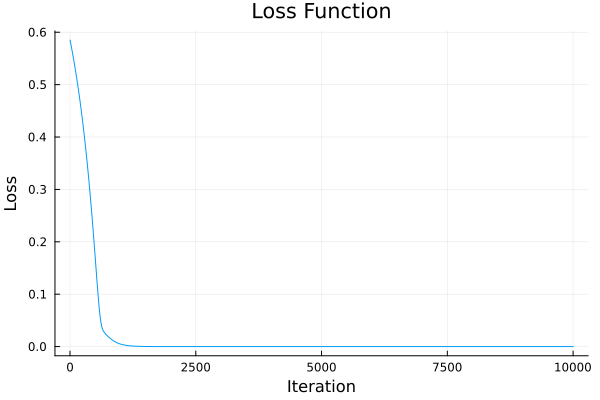

In [27]:
plot_loss(result["loss_history"], savefig=false)

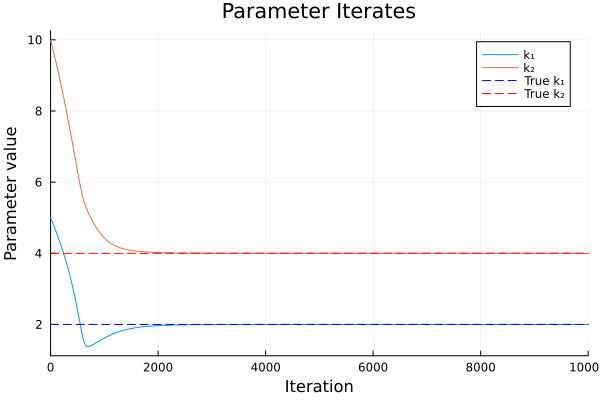

In [137]:
plot_params(result["k1_history"],result["k2_history"])

Lot's of numerical methods to solve PDE's involve an *assembly* of some sort of matrix (canonically the stiffness and deformation matrices). This mutates the matrices which can cause issues for alot of packages out there that do AD in Julia. 

This is especially tricky when we have a changing mesh, like adaptive meshing (Aritrary Lagrangian Eulerian methods). Even h-refinement would not be trivial.

There are alot of open questions in this field!

## Some really good resources to check out

<a id="1">[1]</a> 
Sapienza, Facundo, et al. 
"Differentiable programming for differential equations: A review." 
arXiv preprint arXiv:2406.09699 (2024).

<a id="2">[2]</a> 
Baydin, Atilim Gunes, et al. "Automatic differentiation in machine learning: a survey." Journal of machine learning research 18.153 (2018): 1-43.

<a id="3">[3]</a> 
[Tutorial on AD](https://theoryandpractice.org/stats-ds-book/autodiff-tutorial.html)

<a id="4">[4]</a> 
[AD for Computational Engineering](https://kailaix.github.io/ADCMESlides/AD.pdf)

<a id="5">[5]</a> 
[Parallel Computing and Scientific Machine Learning (SciML): Methods and applications](https://book.sciml.ai/)

<a id="6">[6]</a> 
Clifford. "Preliminary sketch of biquaternions." Proceedings of the London Mathematical Society 1.1 (1871): 381-395.

<a id="7">[7]</a> 
Revels, Jarrett, Miles Lubin, and Theodore Papamarkou. "Forward-mode automatic differentiation in Julia." arXiv preprint arXiv:1607.07892 (2016).